In [2]:
# Import pymongo stuff
import pymongo
import pprint
import json
import warnings
import pandas as pd 
from bson import ObjectId
warnings.filterwarnings('ignore')

myclient = pymongo.MongoClient('mongodb://localhost:27017')
db = myclient["oceanbears"] 

## MongoDB Queries

### Query 2: Get performance of the lessons by theacher
The goal is to track average rating per lesson in order to understand instructors popularity and performance.

In [3]:
aggregation = [
    {
        '$lookup': {
            'from': 'takes_lessons', 
            'localField': '_id', 
            'foreignField': 'lesson_id', 
            'as': 'lessons_taken'
        }
    }, {
        '$addFields': {
            'avgRating': {
                '$avg': '$lessons_taken.rating'
            }
        }
    }, {
        '$lookup': {
            'from': 'surf_teachers', 
            'localField': 'is_given_by_surf_teacher', 
            'foreignField': '_id', 
            'as': 'teacher'
        }
    }, {
        '$lookup': {
            'from': 'locations', 
            'localField': 'beach_location', 
            'foreignField': '_id', 
            'as': 'location'
        }
    }, {
        '$unwind': {
            'path': '$teacher', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$unwind': {
            'path': '$location', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$project': {
            'teacher_id': '$teacher._id', 
            'teacher_name': '$teacher.p_name', 
            'lesson_id': '$_id', 
            'location_id': '$location._id', 
            'latitude': '$location.latitude', 
            'longitude': '$location.longitude', 
            'average_rating': '$avgRating', 
            'total_students': {
                '$size': '$lessons_taken'
            }, 
            'revenue': '$total_price_paid'
        }
    }
]

In [4]:
def get_lessons_performance():
    perf = pd.DataFrame(db["lessons"].aggregate(aggregation))
    return perf

In [5]:
lessons_performance = get_lessons_performance()
lessons_performance.head()

,_id,teacher_id,teacher_name,lesson_id,location_id,latitude,longitude,average_rating,total_students,revenue
0,626720ec892ffbdfb6127187,62671b9cbb13db8215b3d6e3,Erin Velazquez,626720ec892ffbdfb6127187,6267204b892ffbdfb6127150,-44.2408495,-76.551521,2.888889,9,175
1,626720ec892ffbdfb6127188,62671b31bb13db8215b3d5e3,Danielle Bennett,626720ec892ffbdfb6127188,6267204b892ffbdfb6127150,-44.2408495,-76.551521,1.666667,6,175
2,626720ec892ffbdfb6127189,62671b31bb13db8215b3d5ce,Tyler Ward,626720ec892ffbdfb6127189,626720ba892ffbdfb6127172,21.9622875,4.532076,2.000000,9,105
3,626720ec892ffbdfb612718a,62671b9cbb13db8215b3d716,Christopher Escobar,626720ec892ffbdfb612718a,6267204b892ffbdfb6127160,43.088794,-26.655581,3.666667,3,70
4,626720ec892ffbdfb612718b,62671b31bb13db8215b3d5de,Paul Morales,626720ec892ffbdfb612718b,626720ba892ffbdfb6127176,-59.6851735,-114.048823,3.250000,12,70


<AxesSubplot:ylabel='Frequency'>

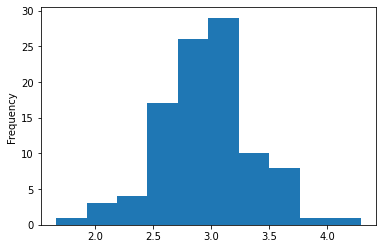

In [6]:
lessons_performance.average_rating.plot.hist()

<AxesSubplot:ylabel='Frequency'>

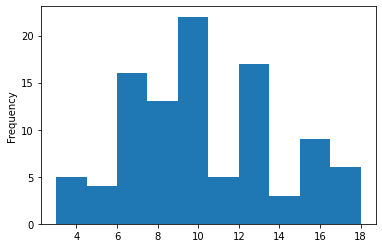

In [7]:
lessons_performance.total_students.plot.hist()

<AxesSubplot:ylabel='Frequency'>

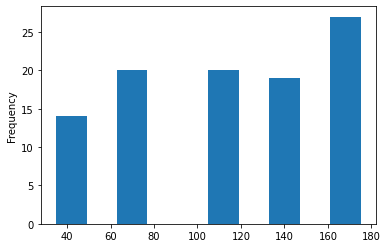

In [8]:
lessons_performance.revenue.plot.hist()

#### Top rated lessons

In [13]:
sorted = lessons_performance.sort_values(by="average_rating", ascending=False)[['teacher_id', 'teacher_name', 'average_rating']]
sorted.head(5)

,teacher_id,teacher_name,average_rating
22,62671b9cbb13db8215b3d73c,Angela Schultz,4.285714
78,62671b9cbb13db8215b3d75a,Andrew Anderson,3.800000
32,62671b9cbb13db8215b3d750,Sharon Reed,3.666667
3,62671b9cbb13db8215b3d716,Christopher Escobar,3.666667
80,62671b9cbb13db8215b3d757,Sarah Bautista,3.625000


#### Top revenue lessons

In [17]:
sorted = lessons_performance.sort_values(by="revenue", ascending=False)[['teacher_id', 'teacher_name', 'revenue']]
sorted.head(5)

,teacher_id,teacher_name,revenue
0,62671b9cbb13db8215b3d6e3,Erin Velazquez,175
69,62671b31bb13db8215b3d5b2,Melanie Todd,175
35,62671b31bb13db8215b3d59c,Erin Guerrero,175
43,62671b9cbb13db8215b3d740,James Butler,175
49,62671b9cbb13db8215b3d6ee,Joann Hall,175


#### Most popular lessons

In [18]:
sorted = lessons_performance.sort_values(by="total_students", ascending=False)[['teacher_id', 'teacher_name', 'total_students']]
sorted.head(5)

,teacher_id,teacher_name,total_students
70,62671b9cbb13db8215b3d708,Derrick Mitchell,18
34,62671b31bb13db8215b3d59c,Erin Guerrero,17
61,62671b31bb13db8215b3d598,Kelsey Thomas,17
79,62671b9cbb13db8215b3d737,Tony Taylor,17
21,62671b9cbb13db8215b3d6b9,Brian Nash,17


### Worst rated lessons

In [20]:
sorted = lessons_performance.sort_values(by="average_rating", ascending=True)[['teacher_id', 'teacher_name', 'average_rating']]
sorted.head(5)

,teacher_id,teacher_name,average_rating
1,62671b31bb13db8215b3d5e3,Danielle Bennett,1.666667
2,62671b31bb13db8215b3d5ce,Tyler Ward,2.000000
43,62671b9cbb13db8215b3d740,James Butler,2.000000
60,62671b31bb13db8215b3d5a6,Terrence White,2.133333
85,62671b9cbb13db8215b3d70a,Andrew Washington,2.333333
